# Packages

In [1]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras import backend as kb
import matplotlib.pyplot as plt
%run Neural_Networks.ipynb # Imports Neural Network
%run Simulation.ipynb # Imports Simulation for MC pricing
plt.style.use('ggplot')

# Parameters

In [2]:
# Model parameters 
mu = 0.1
sigma = 0.3
S0 = 100
K = 100
r = 0.05
T = 30/365

# Simulation parameters
steps = 30
n_train = 100000
n_test = 10000
dt = T/steps

# Neural Network parameters
epochs = 10
learn_rate = 0.001
batch_size = 100
neurons = 200 # Number of neurons in hidden layers
n_hidden_layers = 4 # Number of hidden layers
n_inputs = 3 # time, logS_t-logS0, log(1/n*sum(S_1,...,S_t)) - logS0
n_outputs = 1 # delta

In [3]:
xi_train = npr.normal(0,np.sqrt(dt),(n_train,steps)) # Makes an (n x steps) matrix full of N(0,1/steps) realizations
W_train = np.apply_along_axis(np.cumsum,1,xi_train) # Cumulatively adds the realizations along each row
W_train = np.concatenate((np.zeros((n_train,1)),W_train),1) # Adds zeros in the first column of the matrix
drift = np.linspace(0,(mu-0.5*sigma**2)*T,steps+1) # Makes a (steps+1) length vector of equidistant values, ranging from 0 to mu
drift = np.reshape(drift,(1,steps+1)) # Converts the array into a matrix (with only 1 row)
drift_train = np.repeat(drift,n_train,axis=0) # Repeats the row n times
S_train = S0 * np.exp(drift_train + sigma * W_train) # Calculates S(t) at all timesteps and paths
dS_train = np.diff(S_train,1,1) # Calculates the change in S between each time point
time_grid = np.linspace(0,T,steps+1) # Time array

In [4]:
asianprice = MCprice_BS(option_type='asian',n_paths=1000000)
asianprice

2.131200810630705

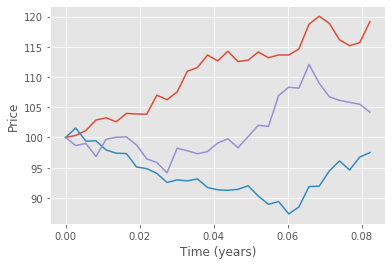

In [5]:
plt.plot(time_grid,S_train[0],time_grid,S_train[1],time_grid,S_train[2])
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.show()
#plt.savefig("BSpaths.png",dpi=500,bbox_inches="tight")

In [6]:
input_train = []
for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_train)
    time_rep = np.reshape(time_rep,(n_train,1))
    logS_train = np.reshape(np.log(S_train[:,i])-np.log(S0),(n_train,1))
    cumsum_train = np.reshape((np.log(np.cumsum(S_train,axis=-1)/np.arange(1,steps+2))-np.log(S0))[:,i],(n_train,1))
    input_train.append(np.concatenate((time_rep,logS_train,cumsum_train),1))

In [7]:
# 3 terms: Price of a call option, the value of the hedge portfolio, the payoff of the call option
def value_pf(y_true,y_pred):
    S = S0
    Vpf = asianprice
    B = Vpf - y_pred[:,0]*S
    for i in range(1,steps):
        S += y_true[:,i-1]
        Vpf = y_pred[:,i-1]*S+B*kb.exp(r*dt)
        B = Vpf - y_pred[:,i]*S
    S += y_true[:,-1]
    Vpf = y_pred[:,-1]*S+B*kb.exp(r*dt)
    return Vpf
        
def loss_asian(y_true,y_pred):
    S = S0+kb.cumsum(y_true,axis=-1)
    A = kb.mean(S,axis=-1)
    return (value_pf(y_true,y_pred) - kb.maximum(A - K,0.))**2

In [8]:
model = FFNN('sigmoid',n_inputs,n_outputs,loss_asian, learn_rate,neurons,n_hidden_layers)

In [9]:
model.fit(input_train,dS_train,batch_size=batch_size,epochs=epochs)
#model.save('BS Asian')
#model = tf.keras.models.load_model('BS Asian', compile=False)

Epoch 1/10
1000/1000 [==============================] - 28s 24ms/step - loss: 0.3331
Epoch 2/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.1641
Epoch 3/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1597 - ETA: 0s - loss:
Epoch 4/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1577
Epoch 5/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1566
Epoch 6/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1561
Epoch 7/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.1552
Epoch 8/10
1000/1000 [==============================] - 28s 28ms/step - loss: 0.1543
Epoch 9/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.1551
Epoch 10/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.1537


# Test

In [10]:
xi_test = npr.normal(0,np.sqrt(dt),(n_test,steps)) # Makes an (n x steps) matrix full of N(0,1/steps) realizations
W_test = np.apply_along_axis(np.cumsum,1,xi_test) # Cumulatively adds the realizations along each row
W_test = np.concatenate((np.zeros((n_test,1)),W_test),1) # Adds zeros in the first column of the matrix
drift = np.linspace(0,(mu-0.5*sigma**2)*T,steps+1) # Makes a (steps+1) length vector of equidistant values, ranging from 0 to mu
drift = np.reshape(drift,(1,steps+1)) # Converts the array into a matrix (with only 1 row)
drift_test = np.repeat(drift,n_test,axis=0) # Repeats the row n times
S_test = S0 * np.exp(drift_test + sigma * W_test) # Calculates S(t) at all timesteps and paths
dS_test = np.diff(S_test,1,1) # Calculates the change in S between each time point

In [11]:
#np.save('asian_test',S_test)
#S_test = np.load('asian_test.npy')
#dS_test = np.diff(S_test,1,1) # Calculates the change in S between each time point

In [12]:
input_test = []
for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_test)
    time_rep = np.reshape(time_rep,(n_test,1))
    logS_test = np.reshape(np.log(S_test[:,i])-np.log(S0),(n_test,1))
    cumsum_test = np.reshape((np.log(np.cumsum(S_test,axis=-1)/np.arange(1,steps+2))-np.log(S0))[:,i],(n_test,1))
    input_test.append(np.concatenate((time_rep,logS_test,cumsum_test),1))

In [13]:
delta_NN_test = model.predict(input_test)
Vpf_NN = asianprice
b = Vpf_NN - delta_NN_test[:,0]*S0
for i in range(1,steps):
    Vpf_NN = delta_NN_test[:,i-1]*S_test[:,i]+b*np.exp(r*dt)
    b = Vpf_NN - delta_NN_test[:,i]*S_test[:,i]
Vpf_NN = delta_NN_test[:,-1]*S_test[:,-1]+b*np.exp(r*dt)
Vpf_NN = np.array(Vpf_NN)

In [14]:
payoff_asian = np.maximum(np.mean(S_test[:,1:],axis=-1)-K,0)

In [15]:
PnL_NN = Vpf_NN - payoff_asian
MSE_NN = np.sum(PnL_NN**2)/n_test

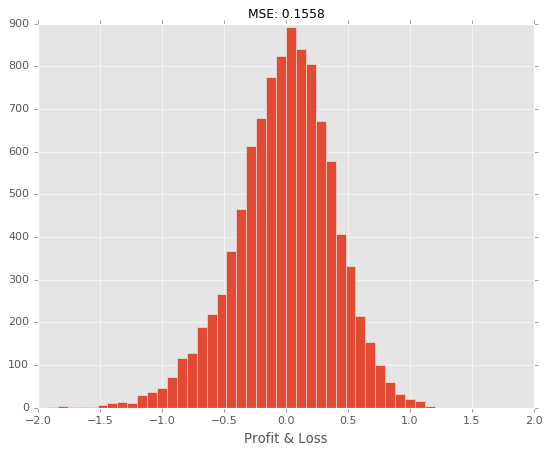

In [16]:
with plt.style.context(['classic', 'ggplot']):
    plt.hist(PnL_NN, bins=50,range=(-2,2))
    plt.title(r'MSE: %1.4f' % MSE_NN, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
plt.show()
#plt.savefig("BS_PnL_asian_NN.png", dpi=500,bbox_inches="tight")

# Monte-Carlo

In [17]:
n_mc = 100000
xi_mc = npr.normal(0,np.sqrt(dt),(n_mc,steps)) # Makes an (n x steps) matrix full of N(0,1/steps) realizations
W_mc = np.apply_along_axis(np.cumsum,1,xi_mc) # Cumulatively adds the realizations along each row
W_mc = np.concatenate((np.zeros((n_mc,1)),W_mc),1) # Adds zeros in the first column of the matrix
drift_mc = np.linspace(0,(r-0.5*sigma**2)*T,steps+1) # Makes a (steps+1) length vector of equidistant values, ranging from 0 to mu
drift_mc = np.reshape(drift_mc,(1,steps+1)) # Converts the array into a matrix (with only 1 row)
drift_mc = np.repeat(drift,n_mc,axis=0) # Repeats the row n times
S_mc = S0 * np.exp(drift_mc + sigma * W_mc) # Calculates S(t) at all timesteps and paths

In [18]:
delta_asian_test = np.empty([n_test,steps])
for i in range(n_test):
    if (i % 1000 == 0): print(i)
    for j in range(steps):
        sum1 = 1/steps*np.sum(S_test[i,:j])
        sum2 = np.sum(S_mc[:,(j+1):],axis=-1)/(steps*S_mc[:,j])
        rhs = (K-sum1)/S_test[i,j]
        indicator = (sum2>rhs)
        delta_asian_test[i,j]=np.mean(indicator*sum2)
    #np.save('delta_asian_test',delta_asian_test)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [19]:
Vpf_m = asianprice
b = Vpf_m - delta_asian_test[:,0]*S0
for i in range(1,steps):
    Vpf_m = delta_asian_test[:,i-1]*S_test[:,i]+b*np.exp(r*dt)
    b = Vpf_m - delta_asian_test[:,i]*S_test[:,i]
Vpf_m = delta_asian_test[:,-1]*S_test[:,-1]+b*np.exp(r*dt)
Vpf_m = np.array(Vpf_m)

In [20]:
PnL_m = Vpf_m - payoff_asian
MSE_m = np.sum(PnL_m**2)/n_test

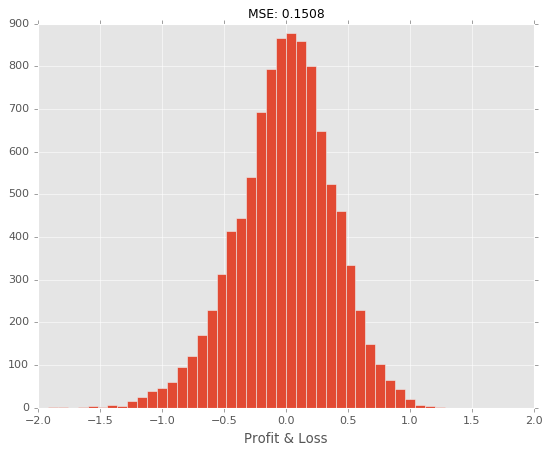

In [21]:
with plt.style.context(['classic', 'ggplot']):
    plt.hist(PnL_m, bins=50,range=(-2,2))
    plt.title(r'MSE: %1.4f' % MSE_m, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
plt.show()
#plt.savefig("BS_PnL_asian_NN.png", dpi=500,bbox_inches="tight")

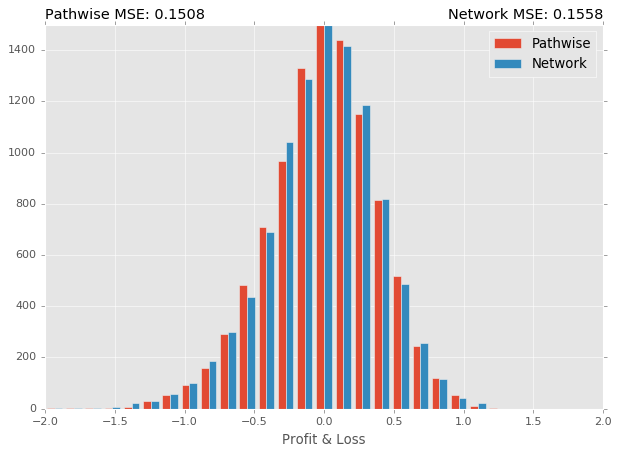

In [22]:
with plt.style.context(['classic','ggplot']):
    plt.figure(figsize=(9,6))
    bins = np.linspace(-2, 2, 30)
    plt.hist([PnL_m, PnL_NN], bins, label=['Pathwise', 'Network'])
    plt.legend(loc='upper right')
    plt.xlabel("Profit & Loss")
    plt.title(r'Pathwise MSE: %1.4f' % MSE_m, loc='left', fontsize=13)
    plt.title(r'Network MSE: %1.4f' % MSE_NN, loc='right', fontsize=13)
    plt.ylim(0, 1500)
plt.show()
#plt.savefig('asian_PnL.png',dpi=500,bbox_inches="tight")